In [1]:
# In this notebook you will learn basic information about redispatching capabilities offered by grid2op.

**Objectives**

As for now, we presented a type of action available in grid2op: a discrete action space. Redispatching is a kind of continuous action that will be described here.

This notebook will:

- present what is redispatching
- show how it can be used in grid2op
- detail the actions related to it
- show an example of a redispatching Agent.

In [1]:
import os
import sys
import grid2op
from grid2op.Agent import DoNothingAgent, BaseAgent
from tqdm.notebook import tqdm
import numpy as np
max_iter = 100  # to make computation much faster we will only consider 100 time steps
import pdb
import matplotlib.pyplot as plt

In [3]:
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

## How to implement redispatching actions

### Having a suitable environment

In [2]:
env_wrong = grid2op.make("rte_case5_example", test=True)
print("Is this environment suitable for redispatching: {}".format(env_wrong.redispatching_unit_commitment_availble))

/home/tezirg/Code/Grid2Op.BDonnot/getting_started/grid2op/MakeEnv/Make.py:223: UserWarning: You are using a development environment. This environment is not intended for training agents.
  warnings.warn(_MAKE_DEV_ENV_WARN)


Is this environment suitable for redispatching: True


As we can see, on the cell above, the simple environment example is not suitable for redispatching. By default, some environments doesn't specify the cost of generators, their maximum and minimum production values etc. In this case it is not possible to use this grid2op feature. 

To know more about what is needed for using redispatching, it is advised to look at the online help https://grid2op.readthedocs.io/en/latest/space.html#grid2op.Space.GridObjects.redispatching_unit_commitment_availble for the most recent documentation. When this notebook was created, what was needed was:

- "gen_type": the type of generator
- "gen_pmin": the minimum value a generator can produce
- "gen_pmax" : the maximum value a generator can produce
- "gen_redispatchable": is this generator can be dispatched
- "gen_max_ramp_up": the maximum increase of power a generator can have between two consecutive time steps
- "gen_max_ramp_down": the maximum decrease of power a generator can have between two consecutive time steps
- "gen_min_uptime": the minimum time a generator need to be turned on (it's impossible to disconnect it if it's not connected for a least "gen_min_uptime" consecutive time step)
- "gen_min_downtime": same as above, but for down time
- "gen_cost_per_MW": the generation cost. For each MW how much is paid
- "gen_startup_cost": the cost to start a generator
- "gen_shutdown_cost": the cost to shutdown a generator

We made available a dedicated environment, based on the IEEE case14 powergrid that has all this features. It is advised to use this small environment for testing and get familiar with this feature.

This environment counts 5 generators, like the original case14 system. It has one solar and one wind generator (that cannot be dispatched), one nuclear powerplant (dispatchable) and 2 thermal generators (dispatchable also). This problem is then a problem of continuous control with 3 degress of freedom.

In [3]:
env = grid2op.make("rte_case14_redisp", test=True)
print("Is this environment suitable for redispatching: {}".format(env.redispatching_unit_commitment_availble))

/home/tezirg/Code/Grid2Op.BDonnot/getting_started/grid2op/MakeEnv/Make.py:223: UserWarning: You are using a development environment. This environment is not intended for training agents.
  warnings.warn(_MAKE_DEV_ENV_WARN)


Is this environment suitable for redispatching: True


We can notice 2 things:

- There is a warning about the number of scenarios available for this small environment. 2 scenarios are include in the pypi package. Please see the documentation if you want more.
- This environment is indeed suitable for redispatching. It means all quantities described above are set (and visible).

In the L2RPN 2019 challenges, we rewarded participants based on the utilization of the powerline. In next challenges, or for other usage of this platform where redispatching plays a role, it's better to consider the economic cost of the sytem. However, usually the cost is minimized, while the reward is maximized. To take this into account, a simplistic reward named "EconomicReward" has been created. It has the following property:

- it returns -1 if there has been a game over
- otherwise (no game over, no error, etc.) it is always strictly positive
- maximizing this reward is equivalent to minimizing the cost


Note that this reward doesn't take into account the cost to perform a redispatching action. This reward can be used to build what is called an "economic dispatch", a problem especially interesting for electricity producers that is of lower interest for Transmission System Operators (as opposed to the topology).

Compared to standard "economic dispatch" problems, for now storages are not implemented (coming soon) and we don't fully take into account startup cost, shutdown cost, as well as min downtime and min uptime (even though all of these features are implemented). Also, note that the redispatching is implemented in "delta" it means you need first to provide an economic dispatch, and then you reason in terms of variation compare to it. This is the usage explained in this notebook. For real unit commitment / economic dispatch problem the key words "injections" / "prod_p" in the action would probably be much suited.

### Redispatching implementation

Unlike topological actions, that are always feasible (assumption made in this package) redispatching actions are limited by physical constraints on the generators. For example:

- it is not possible for a generator to produce more (resp. less) than pmax (resp. pmin). Unlike the curent flow on the powerline, this is an hard physical constraints.
- it is not possible, for the same physical limitations to increase (or decrease) too much the value between two consecutive time steps.
- redispatching actions stack with one another. It means if you ask to augment the production of generator 1 of $10MW$ at time step t, and of $20MW$ at time step $t+1$, it means the set point at time step $t+1$ will be $+30MW$ at this time step compared to a sate where no redispatching is made (it would have been of $+10MW$ if the second redispatching action were not performed).

Having said this, a lot of thing can happen, that makes redispatching a bit less trivial than topology:
- When you do a redispatching action, you don't know what the time series of the environment look like. For example, say the pmax of generator 1 is 100. The setpoint of this generator at time t is $60MW$, and you want to increase its value of $40MW$. This action is legal: $60+40 \leq pmax (=100) $. So at time $t$ everything is fine. Now let's suppose the environment also moved the setpoint of this same generator from $60$ to be at $70MW$ at time $t+1$. With the redispatching action, this would mean the setpoint asked is $70+40 = 110 > pmax$. This is not possible. In this case, the redispatching action will be capped. Among the desired redispatching of $+40$, only $+30$ will be implemented on the powergrid. 
- Another problem can arise with the fundamental principle of power grid: power energy cannot be stored on a grid. At each time we then have $\sum \text{Prod} = \sum \text{Load} + \text{Losses}$. In this competition, the data are generated such that this condition holds (approximately) for all time steps. This means that if you ask a redispatching of +xxx MW on a given generator, then the other one must compensate and "absorb" xxx MW such that it sums at 0 overall.

Out of simplicity for the participants, there are some "automaton" that automatically transform an proposed redispatching action into a valid redispatching action. These automatons basically ensure that the two above-mentionned conditions hold. It explains the differences between "target_redispatching" which is the setpoint enter by the agent, and the "actual_redispatching" which what has been implemented on the powergrid after these automatons work.

### More cases for ambiguous actions

In [4]:
env.gen_redispatchable

array([ True,  True, False, False,  True])

The above vector says which generator is dispatchable and which is not. Any attempt to dispatch a generator that is not dispatchable leads to an ambiguous action.

In [5]:
act = env.action_space({"redispatch": [(2,+10)]})
act.is_ambiguous()

(True,
 Grid2OpException AmbiguousAction InvalidRedispatching InvalidRedispatching('Trying to apply a redispatching action on a non redispatchable generator',))

As we see, this action is ambiguous. And this is ambiguous due to `Trying to apply a redispatching action on a non redispatchable generator`.

Generators have also physical constraints. You cannot ask them to change the active production value too fast, this would damage the generator, and breaking a nuclear plant is often a terrible idea. In grid2op it is implemented as ambiguous action. Trying to go beyond this value will result in an ambiguous action.

This value is called the "ramp" and it's available through the "max_ramp_up" attribute. On the next cell, you see the ramp is of $5$ for the first generator, for $10$ for second and last generators. For the other 2 it's irrelevant because they are not dispatchable.

In [6]:
env.gen_max_ramp_up

array([ 5., 10.,  0.,  0., 10.], dtype=float32)

Any attempt to go beyond this value will raise an ambiguous error (remember index in python starts at 0).

In [7]:
act = env.action_space({"redispatch": [(0,+10)]})
act.is_ambiguous()

(True,
 Grid2OpException AmbiguousAction InvalidRedispatching InvalidRedispatching('Some redispatching amount are above the maximum ramp up',))

In the previous action, we asked the generator 0 to produce 10MW more than it's setpoint. However, the maximum ramp up is only of 5MW. This action is then ambiguous.

And of course, there are some perfectly valid redispatching action:

In [8]:
act = env.action_space({"redispatch": [(1,+10)]})
act.is_ambiguous()

(False, None)

### The setpoint is not the implementation

As said in the preamble of this section, the target dispatching, what we want to achieve (the target), is not equal to the dispatching implemented. To make transparent what is being done, both these values are present in the observation, as shown in the cell below.

In [9]:
observed = []
# perform a valid redispatching action
env.set_id(0)  # make sure to use the same environment input data.
obs_init = env.reset()  # reset the environment
act = env.action_space()
act = env.action_space({"redispatch": [(0,+5)]})
# act = env.action_space({"redispatch": [(0,0)]})
obs, reward, done, info = env.step(act)
print (obs.actual_dispatch)
observed.append(obs)

[ 5.  -2.5  0.   0.  -2.5]


The target dispatch is exactly what we wanted, eg increasing generator with id 0 of +5 MW. To compensate for this increase, both generator 1 and 4 have seen their setpoint diminish from 2.5MW.

Lets draw the generators productions in the scenario and what is implemented with redispatching :

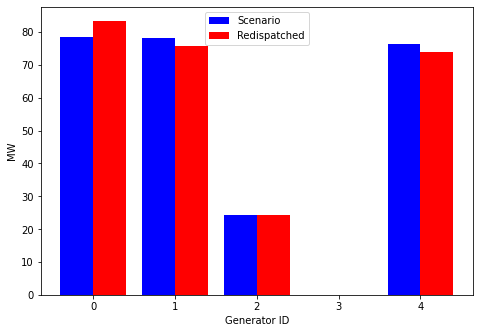

In [10]:
# Create a matplot figure
redisp_fig = plt.figure()
ax = redisp_fig.add_axes([0,0,1,1])
# X axis is the generators
x_gens = np.arange(obs.n_gen)
# Y axis is the production in MW
y_scenario_p = obs.prod_p - obs.actual_dispatch
y_redisp_p = obs.prod_p
# Blue bars for scenario productions
ax.bar(x_gens - 0.2, y_scenario_p, color = 'b', width = 0.4)
# Red bars for production with redispatch
ax.bar(x_gens + 0.2, y_redisp_p, color = 'r', width = 0.4)
# Set some legend to describe what's above
ax.set_ylabel('MW')
ax.set_xlabel('Generator ID')
ax.legend(labels=['Scenario', 'Redispatched'])

In the following cell, we wont be performing any redispatching action. We just do nothing. This example is here to illustrate that, until the original redispatching action is removed (ie until the opposite command is sent), grid2op will continue to apply the previous redispatching configuration over time.

In [11]:
donothing = env.action_space()
obs1, reward, done, info = env.step(donothing)
print(obs1.actual_dispatch)
observed.append(obs1)
obs2, reward, done, info = env.step(donothing)
print(obs2.actual_dispatch)
observed.append(obs2)

[ 5.  -2.5  0.   0.  -2.5]
[ 5.  -2.5  0.   0.  -2.5]


Here, the original redispatching action is to increase of +5MW generator 0, in this case removing it means decreasing it of 5MW :

In [12]:
act = env.action_space({"redispatch": [(0,-5)]})
# act = env.action_space({"redispatch": [(0,0)]})
obs3, reward, done, info = env.step(act)
print (obs3.actual_dispatch)
observed.append(obs3)

[ 1.3093605  -0.65364826  0.          0.         -0.6557123 ]


As we see in the cell above, there are still a residual on the dispatch. This is because of the physical limit of the ramp of the generator 0. It was above it's normal setpoint of +5MW (action at cell 10). We wanted it to return to its setpoint value (action cell 12). But at the same time step, the environment also modified the setpoint of this generator of -1.3MW. The ramp down for this step being $5+1.3 = 6.3 > maxrampdown$, grid2op capped the redispatch occuring at this timestep to $maxrampdown$

That is why we can see a small part of the dispatch left. If we wait another timestep and do nothing, the generator will likely be in order.

In [13]:
obs4, reward, done, info = env.step(donothing)
print(obs4.actual_dispatch)
observed.append(obs4)
obs5, reward, done, info = env.step(donothing)
print(obs5.actual_dispatch)
observed.append(obs5)

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


Now everything is set up as it should be. The system is back to its original state. Let's now see what happens if we ask to increase again the value of this generator 0.

In [14]:
act = env.action_space({"redispatch": [(0,+5)]})
# act = env.action_space({"redispatch": [(0,0)]})
obs6, reward, done, info = env.step(act)
print(obs6.actual_dispatch)
observed.append(obs6)
obs7, reward, done, info = env.step(donothing)
print(obs7.actual_dispatch)
observed.append(obs7)
obs8, reward, done, info = env.step(donothing)
print(obs8.actual_dispatch)
observed.append(obs8)

[ 4.6901584 -2.3450909  0.         0.        -2.3450673]
[ 5.        -2.5000007  0.         0.        -2.4999993]
[ 5.        -2.5000002  0.         0.        -2.5      ]


This time we directly see the full (valid) redispatching action is not apply completely. This is due to the same phenomenon that previously. The environment increased the value of this generator, and at the same time, we also ask to increase it of its maximum value. So our action was "capped" and only  4.7MW (out of 5) were indeed produced by the generator. At the next time step, the action would be fully implemented.

To conclude on redispathcin we saw that there is a difference between the value we ask, and the value implemented by the environment. This is mainly to:

- the implemented vector should sum to 0.
- if a redispatching is close to the maximum value it can take (due to ramping limitation or hard limitations) and at the same time the environment itself "wanted" to increase this value, then the physical limitations are respected.

Redispatching action also last in time. One action must be explicitely canceled to be reset to 0. This cancelation, because of the limitations above-mentionned can take a few time step to be fully effective.

To summarize, we can look at the productions over time for generators 0 & 4:

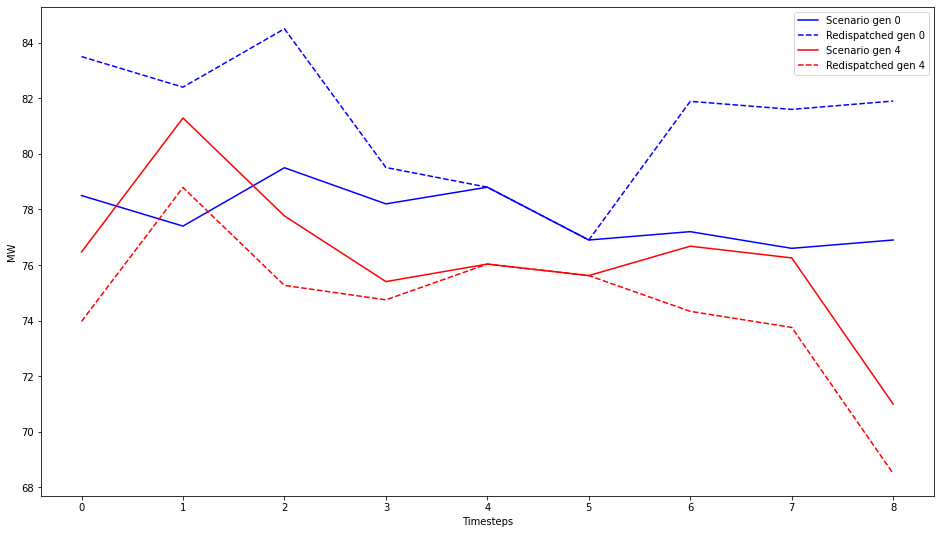

In [17]:
# Create a matplot figure
redisp_fig = plt.figure(figsize=(16, 9))
# X axis is the timesteps
x_gens = np.arange(len(observed), dtype=np.int32)
# Y axis is the production in MW
y_scenario_p_0 = [o.prod_p[0] - o.actual_dispatch[0] for o in observed] 
y_redisp_p_0 = [o.prod_p[0] for o in observed]
y_scenario_p_4 = [o.prod_p[4] - o.actual_dispatch[4] for o in observed] 
y_redisp_p_4 = [o.prod_p[4] for o in observed]
# Blue lines for gen 0
plt.plot(x_gens, y_scenario_p_0, 'b', x_gens, y_redisp_p_0, 'b--')
# Red lines for gen 4
plt.plot(x_gens, y_scenario_p_4, 'r', x_gens, y_redisp_p_4, 'r--')
# Set some legend to describe what's above
plt.ylabel('MW')
plt.xlabel('Timesteps')
plt.legend(labels=['Scenario gen 0', 'Redispatched gen 0', 'Scenario gen 4', 'Redispatched gen 4'])

## Example of use: economic dispatch problem

In [16]:
agent = DoNothingAgent(env.action_space)
done = False
reward = env.reward_range[0]

env.set_id(0)  # make sure to evaluate the models on the same experiments
obs = env.reset()
cum_reward = 0
nrow = env.chronics_handler.max_timestep() if max_iter <= 0 else max_iter
gen_p = np.zeros((nrow, env.n_gen))
gen_p_setpoint = np.zeros((nrow, env.n_gen))
load_p = np.zeros((nrow, env.n_load))
rho = np.zeros((nrow, env.n_line))
i = 0
with tqdm(total=max_iter, desc="step") as pbar:
    while not done:
        act = agent.act(obs, reward, done)
        obs, reward, done, info = env.step(act)
        data_generator = env.chronics_handler.real_data.data
        gen_p_setpoint[i,:] = data_generator.prod_p[data_generator.current_index, :]
        gen_p[i,:] = obs.prod_p
        load_p[i,:] = obs.load_p
        rho[i,:] = obs.rho
        cum_reward += reward
        i += 1
        pbar.update(1)
        if i >= max_iter:
            break
print("The cumulative reward with this agent is {:.0f}".format(cum_reward))


The cumulative reward with this agent is 121369


let's do the same, but forcing as much redispatching as possible on the cheapest generator.

In [18]:
class GreedyEconomic(BaseAgent):
    def __init__(self, action_space):
        super().__init__(action_space)
        self.do_nothing = action_space()
        
    def act(self, obs, reward, done):
        act = self.do_nothing
        if obs.prod_p[0] < obs.gen_pmax[0] - 1 and \
        obs.target_dispatch[0] < (obs.gen_pmax[0] - obs.gen_max_ramp_up[0]) - 1 and\
        obs.prod_p[0] > 0.:
            # if the cheapest generator is significantly bellow its maximum cost
            if obs.target_dispatch[0] < obs.gen_pmax[0]:
                #in theory i can still ask for more
                act = env.action_space({"redispatch": [(0, obs.gen_max_ramp_up[0])]})
        return act
    
agent = GreedyEconomic(env.action_space)
done = False
reward = env.reward_range[0]

env.set_id(0) # reset the env to the same id
obs = env.reset()
cum_reward = 0
nrow = env.chronics_handler.max_timestep() if max_iter <= 0 else max_iter
gen_p = np.zeros((nrow, env.n_gen))
gen_p_setpoint = np.zeros((nrow, env.n_gen))
load_p = np.zeros((nrow, env.n_load))
rho = np.zeros((nrow, env.n_line))
i = 0
with tqdm(total=max_iter, desc="step") as pbar:
    while not done:
        act = agent.act(obs, reward, done)
        obs, reward, done, info = env.step(act)
#         print("act: {}".format(act))
#         print("info: {}".format(info['exception']))
#         if info['exception'] is not None:
        if np.abs(np.sum(obs.actual_dispatch)) > 1e-2:
            pdb.set_trace()
        data_generator = env.chronics_handler.real_data.data
        gen_p_setpoint[i,:] = data_generator.prod_p[data_generator.current_index, :]
        gen_p[i,:] = obs.prod_p
        load_p[i,:] = obs.load_p
        rho[i,:] = obs.rho
        cum_reward += reward
        i += 1
        pbar.update(1)
        if i >= max_iter:
            break
print("The cumulative reward with this agent is {:.0f}".format(cum_reward))


The cumulative reward with this agent is 97832
